In [1]:
city_name = 'Reims' # just for saving the file
metric_projection = 'EPSG:27563' # search for a valid metric projection code for your city
timezone = 'Europe/Paris'

In [2]:
# # check if timezone exists
assert timezone in __import__('pytz').all_timezones, "Set correct Timezone"

# IMPORT THE AOI

But for better customization I suggest using geojson.io

In [3]:
%cd /home/ludovico/mounted/SynthGPS
 
import geomob
from synth_gps.utils import get_and_save_bbox

AOI = f'aoi_{city_name}.geojson'

# retrieve the data (according to OSM api policy, you should provide your email)
city_shape = geomob.retrieve_osm(city_name, "SynthGPS Downloader (yourmailhere)").loc[[0]]
get_and_save_bbox(city_shape, AOI)

/home/ludovico/geo_venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/ludovico/mounted/SynthGPS


In [ ]:
geomob.plot_gdf(city_shape)

# GET DATA FROM OVERTURE AND GOOGLE EE

Here a Spark Session will be set. 
If you have less cores reduce them to the appropriate amount to avoid freezing.

Google Earth Engine will be used to provide the rasters of the building height and population.

In [4]:
from synth_gps.utils import load_resources, get_tiles_wph
import numpy as np

OVERTURE = 'overture_s3_urls.json'

resources = load_resources(n_cores=10, aoi_path=AOI, resources_path=OVERTURE)
pv, rv, bv, aoi = resources['POIS'], resources['ROADS'], resources['BUILDINGS'], resources['AOI']
bbox_tess = get_tiles_wph('ee-ludovicolemma', aoi, metric_projection)

:: loading settings :: url = jar:file:/home/ludovico/geo_venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.sedona#sedona-spark-3.4_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7e8a7a9b-e41f-4f19-97f7-892cf56ab6b6;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-3.4_2.12;1.6.0 in central
	found org.apache.sedona#sedona-common;1.6.0 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found org.locationtech.jts#jts-core;1.19.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.locationtech.spatial4j#spatial4j;0.8 in central
	found com.google.geometry#s2-geometry;2.0.0 in central
	found com.google.guava#guava;25.1-jre in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found org.checkerframework#checker-qual;2.0.0 in central
	found com.google.errorprone#error_prone_annotations;2.1.3 in central
	found com.google.j2objc#j2objc-ann

# PROCESS ROADS

In [ ]:
from synth_gps.roads import RoadProcessor

roads_pipeline = RoadProcessor(rv, metric_projection)

rv = roads_pipeline.roads
G = roads_pipeline.get_graph()

# [HIGHLY SUGGESTED]
If you don't know what you are doing: Run this.


If you know what you are doing you can just provide the Home Locations (Origins), Buildings and POIs (Destinations) yourself.
The requirements are that home locations have a "geometry" and "uid" column, and POIs have a "geometry" and "importance" column, both geometry column must be points, at the moment the buildings must be used anyway for generating static pings, it may change though.

## PROCESS BUILDINGS

<Axes: >

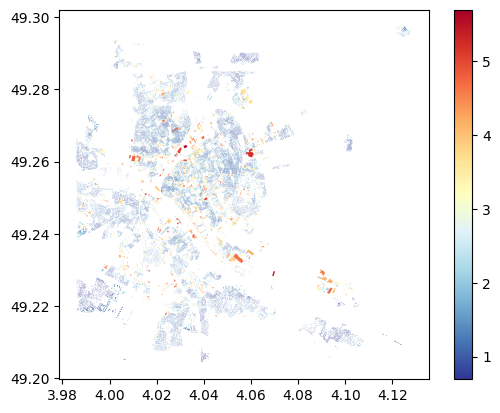

In [14]:
from synth_gps.building import BuildingProcessor, point_filling_geometries
from synth_gps.metadata import generate_uids

bv_inhabitants = BuildingProcessor(bv, metric_projection).get_default_features(bbox_tess)
home_locations = point_filling_geometries(bv_inhabitants, n_point_feature = 'inhabitants')
home_locations['uid'] = generate_uids(len(home_locations))

bv_inhabitants.assign(log_inhabitants = np.log(bv_inhabitants['inhabitants'] + 1))\
              .plot('log_inhabitants', cmap = 'RdYlBu_r', legend = True)

## PROCESS POIs

The criterion used to determine the importance is the "centrality of the POI". I may change it in the future since it has some problems.

In [16]:
from synth_gps.pois import POIsProcessor

poi_pipeline = POIsProcessor(pv, metric_projection)
poi_pipeline.add_building_area(bv)

poi_pipeline.get_poi_centrality()
poi_pipeline.get_poi_importance()

poi_igraph = poi_pipeline.poi_igraph
edge_geoms = poi_pipeline.edge_geoms
pv_processed = poi_pipeline.pois

print(len(poi_igraph.components()), 'components')
print(len(edge_geoms), 'edges')

17 components
16850 edges


Text(0.5, 1.0, 'POIs centrality')

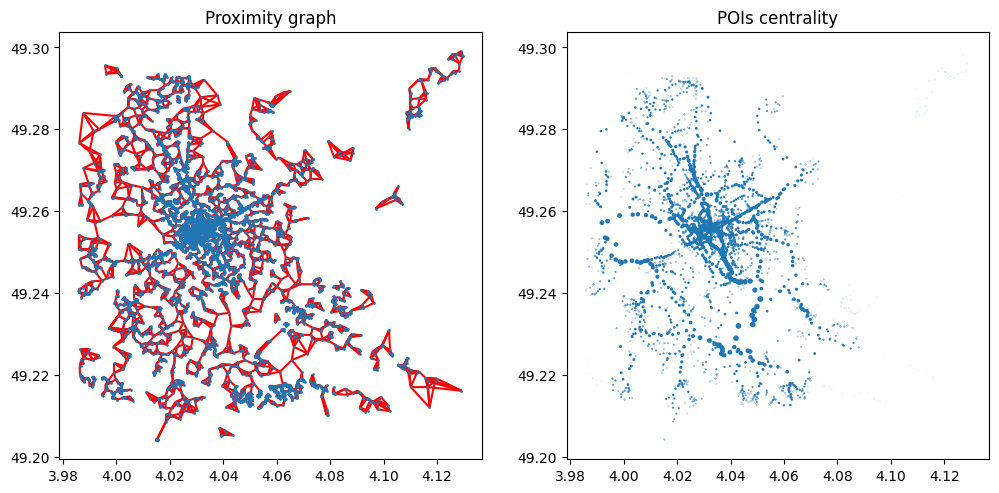

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

edge_geoms.plot(ax = axs[0], zorder = 1, color='red')
pv_processed.plot(markersize=1, ax = axs[0], zorder = 2)
axs[0].set_title('Proximity graph')
pv_processed.plot(markersize=pv_processed['centrality'] * 10 / pv_processed['centrality'].max(), ax = axs[1])
axs[1].set_title('POIs centrality')

# COMPUTE OD

In [18]:
from synth_gps.od import odGenerator
import geopandas as gpd

home_locations_reprojected = home_locations.to_crs(metric_projection)
pv_reprojected = pv_processed.to_crs(metric_projection)
road_nodes = gpd.GeoDataFrame(geometry = G.vs['geometry'], crs = metric_projection)

# in many large cities it is necessary to sample the OD pairs to avoid using too much memory
od_gen = odGenerator(home_locations_reprojected, pv_reprojected, road_nodes)

for _ in range(1):
    od_gen.generate_OD_pairs(kind = 'origins')
    
computational_OD = od_gen.get_computable_OD(which_destination='all')
computed_paths = od_gen.get_paths(G, computational_OD)
trips = od_gen.assign_paths_to_OD(od_gen.od_pairs, computed_paths)
trips['uid'] = trips.index.map(dict(enumerate(od_gen.uids)))

# VISUALIZE TRIPS

In [19]:
agg_trips = od_gen.get_trips_with_size(which_destination = 'D', compute_space = True) # just for visualization
agg_trips.to_csv(f'{city_name}_trips.csv', index = False)

# ASSIGN OCCUPANCY TO ROADS

In [20]:
occupancy_dict = dict(zip(*np.unique(np.concatenate(trips['edge'].values), return_counts=True)))
rv['occupancy'] = rv.index.map(occupancy_dict).fillna(0).astype(int)

# SETTING PARAMETERS

In [21]:
from synth_gps.metadata import SynthGPS

meters_road_buffer = 5
max_pings_per_user = 100
max_days = 1 # Use one to get only one day of data (better to control seasonality and creating a more diverse output)
hour_range = (0, 24)

synthetic_generator = SynthGPS(rv, meters_road_buffer, metric_projection, max_pings_per_user)
h_asset, w_asset, p_asset = synthetic_generator.generate_raw_static_assets(trips, road_nodes, home_locations, bv, pv)

# COMPUTING PINGS

The synthetic GPS data generator proceeds first by generating random points on buildings and roads.
Then it assigns the points by fitting lines according to the user paths and the user expected ping density.

Every random distribution used is approximately a power-law.
Thus the output is similar to what someone can expect from a real dataset.

Reduce the AOI size or the pings per user to speed up the computation.

It executes for the requested number of days, but I did not set any seasonality yet, so the synthetic days are just randomized variations of the typical one. Seasonality may be inserted by changing the max pings per user across the iterations.

nb. I may optimize or enrich it in the future

In [31]:
import pandas as pd
from synth_gps.metadata import get_midnight

get_data_for_days = 30

day = get_midnight()
days = {day + i * 24 * 60 * 60 : pd.DataFrame() for i in range(get_data_for_days)}

for i, day in enumerate(days):
     if days[day].empty:
                    
          synthetic_generator.set_time(max_days, hour_range, timezone, day)
          generated_forward = synthetic_generator.generate_moving_pings(trips, 
                                                                      noise_strength = 100, filter_speed = 200)

          generate_backward = synthetic_generator.generate_moving_pings(trips.assign(edge = trips['edge'].apply(lambda x: x[::-1]))\
                                                                           .rename(columns = {'O' : 'D', 'D' : 'O'}), 
                                                                      noise_strength = 100, filter_speed = 200)

          moving = pd.concat([generated_forward, generate_backward], 
                              ignore_index = True).sort_values('timestamp')\
                                                  .reset_index(drop = True)
                                                  
          hs, ws, ps = synthetic_generator.generate_static_pings(moving['uid'].unique(), 
                                                                 h_asset, w_asset, p_asset, 
                                                                 homes_ratio = 0.30, workplaces_ratio = 0.25, pois_ratio = 0.25, 
                                                                 home_hour_range = (20, 4), work_hour_range = (4, 20), poi_hour_range = (4, 20),
                                                                 noise_strength = 100)

          day_synthetic_dataset = pd.concat([moving, hs, ws, ps], ignore_index = True)\
                                    .sort_values('timestamp')[['uid', 'timestamp', 'geometry']]
          day_synthetic_dataset = day_synthetic_dataset[day_synthetic_dataset['timestamp'] < day + 24 * 60 * 60].copy(deep = True)

          day_synthetic_dataset['lat'] = day_synthetic_dataset['geometry'].apply(lambda x: x.y)
          day_synthetic_dataset['lng'] = day_synthetic_dataset['geometry'].apply(lambda x: x.x)
          day_synthetic_dataset['timestamp'] = day_synthetic_dataset['timestamp'].astype(int)
          day_synthetic_dataset = day_synthetic_dataset.drop('geometry', axis = 1)
          
          days[day] = day_synthetic_dataset
          
full_dataset_synthetic = pd.concat(days.values(), ignore_index = True)
full_dataset_synthetic.to_csv(f'{city_name}_pings.csv', index = False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 202249/202249 [00:36<00:00, 5571.70it/s]
